In [117]:
import gymnasium as gym
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

# parameters

In [118]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

min_position, max_position = -1.2, 0.6
min_velocity, max_velocity = -0.07, 0.07
bins = (40, 40)
episodes = 10000
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.999
min_epsilon = 0.01

pos_space = np.linspace(min_position, max_position, bins[0])
vel_space = np.linspace(min_velocity, max_velocity, bins[1])

# training q table

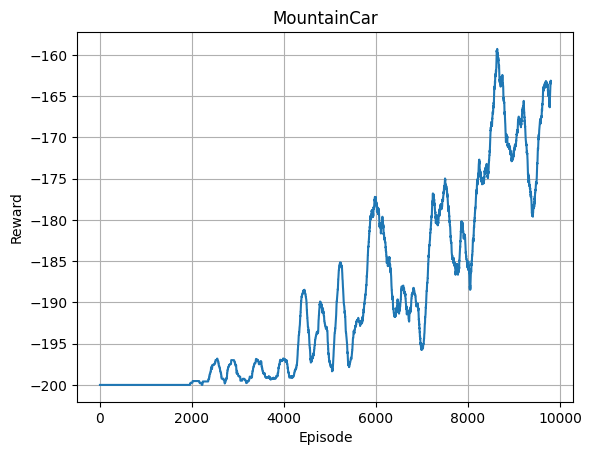

In [119]:
def discretize_state(state):
    pos, vel = state
    pos_bin = np.digitize(pos, pos_space)
    vel_bin = np.digitize(vel, vel_space)
    return (pos_bin, vel_bin)

q_table = np.zeros((bins[0] + 1, bins[1] + 1, env.action_space.n))

episode_rewards = []

for ep in range(episodes):
    state, _ = env.reset()
    state_disc = discretize_state(state)
    total_reward = 0
    terminated = False
    truncated = False

    while not (terminated or truncated):
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_disc])

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state_disc = discretize_state(next_state)

        best_next_action = np.argmax(q_table[next_state_disc])
        td_target = reward + discount_factor * q_table[next_state_disc + (best_next_action,)]
        td_error = td_target - q_table[state_disc + (action,)]
        q_table[state_disc + (action,)] += learning_rate * td_error

        state_disc = next_state_disc
        total_reward += reward

    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

with open("q_table_mountain_car.pkl", "wb") as f:
    pickle.dump(q_table, f)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

plt.plot(smooth(episode_rewards, 200))
plt.title("MountainCar")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig("mountain_car_099_smooth.png")
plt.show()

# game with learned q-table

In [120]:
with open('q_table_mountain_car.pkl', 'rb') as f:
    q_table = pickle.load(f)

state, _ = env.reset()
state_discrete = discretize_state(state)
terminated = False
truncated = False
rewards = 0

while not (terminated or truncated):
    action = np.argmax(q_table[state_discrete])

    next_state, reward, terminated, truncated, _ = env.step(action)
    state_discrete = discretize_state(next_state)
    rewards += reward

    frame = env.render()
    cv2.imshow('Mountain Car Visualization', cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    cv2.waitKey(100)

cv2.destroyAllWindows()
print(f"Total reward: {rewards}")

Total reward: -172.0
